*Sklearn Project*

Using various student statistics (GRE Score, TOEFL Score, CGPA) to predict their chance of being admitted into univeristy.

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

# Data Cleaning, Wrangling, and Model Fitting

In [2]:
admissions = pd.read_csv("Admission_Predict.csv")
admissions

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


In [19]:
#Let's first explore the data
len(admissions)

400

In [3]:
#some cleaning
#first removing whitespace from column headings
cols = list(admissions.columns)
cols = [x.strip() for x in cols]
admissions.columns = cols

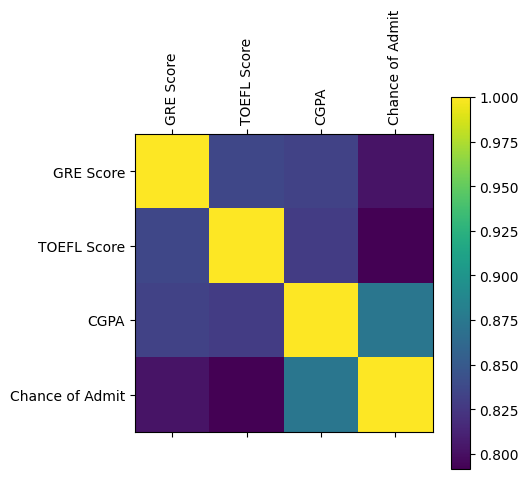

In [4]:
#Simple matrix check - relationships between GRE, TOEEFL, CGPA and chance of admission

subset = admissions[["GRE Score", "TOEFL Score", "CGPA", "Chance of Admit"]]

plt.matshow(subset.corr())
plt.xticks(np.arange(4), subset.columns, rotation = 90)
plt.yticks(np.arange(4), subset.columns)
plt.colorbar()
plt.show()

#there are some strong relationships between model predictors and outputs

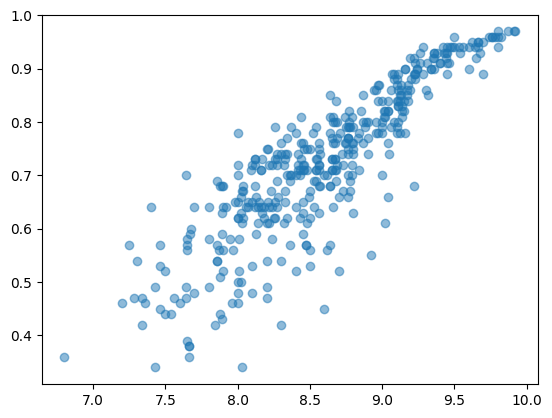

In [5]:
#plotting strongest relationship - that between cgpa and chance of admit
from matplotlib.pyplot import scatter

plt.scatter(subset["CGPA"], subset["Chance of Admit"], alpha=0.5)

In [6]:
#train-test splitting the data into predictors and output variable
from sklearn.model_selection import train_test_split

x = np.asarray(subset[["GRE Score", "TOEFL Score", "CGPA"]])
y = subset["Chance of Admit"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle=True)

In [7]:
from sklearn.linear_model import LinearRegression
#creating and fitting simple linear regression

linReg = LinearRegression()
linReg.fit(x_train, y_train)

LinearRegression()

In [8]:
#checking predictor outputs
print("Predicted Admission Chance: ", linReg.predict(x_test)) 
#checking variable weights
print("Weights: ", linReg.coef_)

Predicted Admission Chance:  [0.65399238 0.907688   0.66732208 0.75068202 0.78284422 0.80395426
 0.75435814 0.9531812  0.87875829 0.80690398 0.85457157 0.95262265
 0.82402977 0.78352145 0.58015688 0.59974812 0.84060529 0.58260202
 0.80140598 0.59132072 0.70081492 0.63310416 0.59582987 0.78511323
 0.58520646 0.54606112 0.65498123 0.81557351 0.78551117 0.8398094
 0.70199672 0.62154237 0.62172704 0.80884453 0.62256007 0.69621595
 0.61901092 0.71969659 0.81993888 0.4537705  0.66422135 0.54528205
 0.67763387 0.65179791 0.82827996 0.68855559 0.74585271 0.97465553
 0.84758843 0.90923061 0.84790859 0.78266809 0.53253846 0.73991962
 0.9314888  0.68382462 0.73071315 0.75439878 0.89316316 0.79277359
 0.54355348 0.71565138 0.73452476 0.60978413 0.46676825 0.49358128
 0.87178368 0.81986939 0.7216     0.70436407 0.78436651 0.68066162
 0.61478957 0.7661332  0.70916453 0.76053686 0.81562269 0.63545948
 0.79303604 0.63341579 0.68602413 0.87445412 0.84994376 0.96199826
 0.88926174 0.78306603 0.93249797 

Unsurprisingly, the third predictor variable - CGPA - is weighted the highest, given that it had the strongest relationship with admission chance.

However, let's keep our initial visualisation from earlier in mind. There were correlations > 0.8 between all of the predictor variables. Our model might be suffering from multicolinearity. 

When multicolinearity is an issue, we can employ ridge regression.

In [9]:
#fitting ridge regression on the same train-test split
from sklearn import linear_model

reg = linear_model.Ridge(alpha = 0.5) #creating ridge model
reg.fit(x_train, y_train)

Ridge(alpha=0.5)

# Model Testing

In [10]:
#let's first compare the models on the basis of R^2 score

print(linReg.score(x_test, y_test))
print(reg.score(x_test, y_test))

#actually quite similar, both explaining around 75-80% of varaince (depending on how the model fit)


0.7692364529123363
0.7687217058570704


__Backtesting__

The dataset is quite small, so we're only training on 300 values and testing on 100. Not really enough to represent real-world performance.

We can iteratively backtest the data to effectively get "more" out of testing. 

In [29]:
#creating backtesting function

def backtester(data, model, parameters, start=40, step=40):
    predictionList = []
    #iterating over the dataset 
    for i in range(start, data.shape[0], step): 
        #traintest split
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        #fitting the reg model at each stage
        model.fit(train[parameters], train["Chance of Admit"])
        #predicted values based on this
        prediction = model.predict(test[parameters])
        prediction = pd.Series(prediction, index=test.index) #series, easier to concat
        #combining predicted value and actual value, then adding to list
        combined = pd.concat({
            "Actual COA": test["Chance of Admit"],
            "Predicted COA": prediction
        }, axis=1)
        predictionList.append(combined)

    return pd.concat(predictionList)


In [30]:
#setting params and using backtester 
params = ["GRE Score", "TOEFL Score", "CGPA", "Chance of Admit"]

predsDF = backtester(admissions, reg, params)
predsDF

,Actual COA,Predicted COA
40,0.46,0.564580
41,0.49,0.596648
42,0.53,0.633893
43,0.87,0.847712
44,0.91,0.867669
...,...,...
395,0.82,0.817688
396,0.84,0.833034
397,0.91,0.908163
398,0.67,0.682439


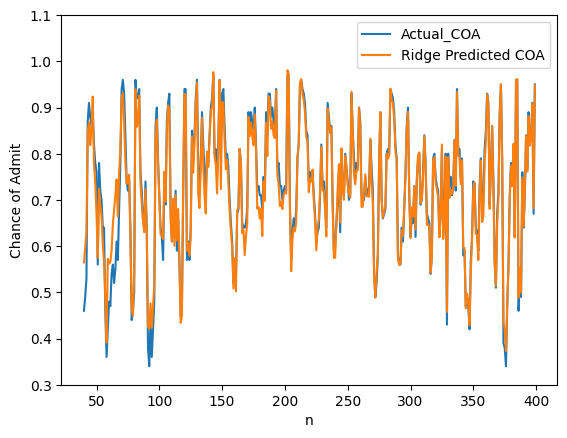

In [42]:
#plotting actual vs. predicted COA 
plt.plot(predsDF["Actual COA"], label="Actual_COA")
plt.plot(predsDF["Predicted COA"], label="Ridge Predicted COA")
plt.legend(loc="upper right")
plt.xlabel("n")
plt.ylabel("Chance of Admit")
plt.ylim(0.3, 1.1)
plt.show()